In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob

In [2]:
import clean_filter_text as cft
import hotel_NMF_PhaseII as ht

In [3]:
reviews = pd.read_csv('../raw_data/deceptive-opinion.csv')
y = reviews['deceptive']
x = reviews.drop('deceptive', axis=1)
x_tv, x_te, y_tv, y_te = train_test_split(x, y, test_size=0.2, random_state=444)
x_tr, x_va, y_tr, y_va = train_test_split(x_tv, y_tv, test_size=0.25, random_state=444)

In [ ]:
# file_df = cft.main_clean(x_tr)
# file_df.to_pickle('../pickles/clean_hotel_reviews.pkl')

In [4]:
file_df = pd.read_pickle('../pickles/clean_hotel_reviews.pkl')

In [5]:
n = 5
ngrams = (1,1)
uni_gram_nmf = ht.nmf_model(file_df, n, ngrams)

         0      1         2         3         4
0  chicago    thi     visit  downtown   definit
1    check   desk      wait    servic     arriv
2     veri  clean     staff      nice  friendli
3    night    thi  bathroom      free     floor
4    great  locat      view     staff      love


In [6]:
ngrams = (1,2)
bigram_nmf = ht.nmf_model(file_df, n, ngrams)

         0          1              2         3          4
0    great      locat           view      walk      night
1    check       desk          night      time     servic
2     veri  room veri      veri nice     clean       nice
3      thi  thi hotel  recommend thi  stay thi  recommend
4  chicago   downtown          visit    luxuri    definit


In [7]:
# Insert column with indices to merge on with matrices post-SVD
def preserve_index(svd_df, old_idx_df):
    svd_df['og_index'] = old_idx_df.index
    return svd_df


In [8]:
# functions for feature engineering/selection to be added in addition to topics
def tb_subjectivity(text):
    sub_score = TextBlob(text).sentiment.subjectivity
    return sub_score

def tb_sentiment(text):
    pol_score = TextBlob(text).sentiment.polairty
    return 'negative' if pol_score < .3 else 'positive'

In [9]:
def add_features_to_topics(topic_df, x_sel, keep_text=False):
    '''
    Takes topic model matrix and adds subjectivity, review length, and dummifies polarity. Also
    adds original index as a column in the topic model matrix.
    '''
    topic_df = preserve_index(topic_df, x_sel)
    x_sel = preserve_index(x_sel, x_sel)
    x_mod = topic_df.merge(x_sel, how='left', on='og_index')
    x_mod.drop(['hotel', 'source', 'og_index'], axis=1, inplace=True)
    x_mod['tb_subjective'] = x_mod['text'].apply(tb_subjectivity)
    x_mod['review_length'] = x_mod['text'].apply(lambda x: len([x for x in x.split()]))
    x_mod['polarity'] = x_mod['polarity'].map({'negative':0, 'positive': 1})
    if keep_text:
        return x_mod
    else:
        return x_mod.drop('text', axis=1)

In [10]:
bigram_nmf

,"great,locat,view,walk,night","check,desk,night,time,servic","veri,room veri,veri nice,clean,nice","thi,thi hotel,recommend thi,stay thi,recommend","chicago,downtown,visit,luxuri,definit"
0,0.073043,0.065412,0.028582,0.042986,0.088793
1,0.140194,0.056084,0.000000,0.004602,0.027383
2,0.002089,0.129239,0.000000,0.000000,0.002188
3,0.192980,0.000000,0.064174,0.000000,0.045297
4,0.000000,0.143329,0.000000,0.016703,0.000000
...,...,...,...,...,...
955,0.031053,0.000000,0.085187,0.104728,0.024398
956,0.000000,0.063713,0.002669,0.206772,0.012342
957,0.005864,0.129928,0.000000,0.107837,0.000000
958,0.032819,0.002181,0.000000,0.053641,0.153236


In [11]:
x_feat = add_features_to_topics(bigram_nmf, x_tr)

<ipython-input-7-2c6173dda70c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svd_df['og_index'] = old_idx_df.index


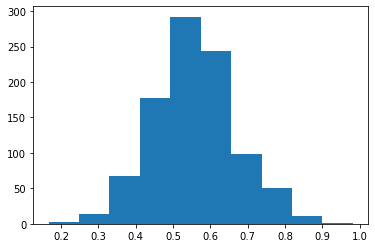

In [12]:
plt.hist(x_feat['tb_subjective'])
plt.show()

# Feature Engineering

# Clustering

## First: Bi-gram with added features

In [ ]:
x_feat

In [13]:
scaler = StandardScaler()
x_feat_sc = scaler.fit_transform(x_feat)

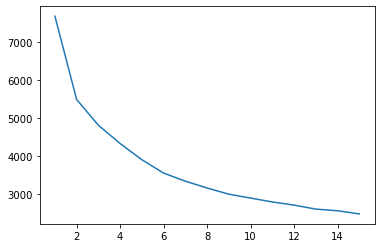

In [14]:
# Find optimal K
def elbow_test(nmf):
    sum_square_dist = []
    k_range = range(1,16)
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=444)
        km.fit(nmf)
        sum_square_dist.append(km.inertia_)
    return k_range, sum_square_dist
    
x_k, y_inertia = elbow_test(x_feat_sc)

plt.plot(x_k, y_inertia)

In [15]:
def kmeans_cluster_range(data, klow, khigh):
    k_df = pd.DataFrame(index=bigram_nmf['og_index'])
    for k in range(klow, khigh+1):
        km = KMeans(n_clusters=k, random_state=444)
        km.fit_predict(data)
        k_df[k] = km.labels_
    return k_df

k_df=kmeans_cluster_range(x_feat_sc,6,12)
k_df['target'] = y_tr

In [16]:
def kmeans_cluster(k, data):
    km = KMeans(n_clusters=k, random_state=444)
    km.fit_predict(data)
    return km

In [17]:
cluster_cents = kmeans_cluster(8, x_feat_sc).cluster_centers_
cluster_cents

array([[-3.27127282e-01,  5.56728788e-01, -1.64566852e-01,
        -4.75569452e-01, -5.50348797e-01, -9.15948854e-01,
         5.65977082e-01, -2.68504090e-01],
       [ 2.80719768e-01, -1.02179403e+00,  2.26323713e-01,
         1.71005611e+00,  1.96903651e-01,  1.01469124e+00,
         9.01841240e-01, -5.98839360e-01],
       [-5.13833368e-01,  7.54864384e-01, -4.09439744e-01,
        -5.03781417e-01, -4.42224181e-01, -8.70859594e-01,
        -1.16489608e+00,  5.32786376e-04],
       [ 1.61513263e+00, -5.84376166e-01,  1.63704761e-02,
        -3.73062960e-01, -2.71119482e-01,  9.41063776e-01,
         3.83647722e-01, -2.98468824e-01],
       [-4.59326990e-01,  9.57038250e-02, -8.39716257e-02,
         1.39488791e+00, -5.00713695e-01, -8.88423765e-01,
        -3.72514517e-01,  9.22221854e-02],
       [-3.23655514e-01, -7.55200859e-01, -3.15488467e-01,
        -2.78130133e-01,  1.65658367e+00,  8.69221223e-01,
         1.77557454e-01, -3.18572828e-01],
       [-5.16605299e-01,  1.572873

In [18]:
# look at first element to determine which topic most matches with the cluster
cluster_num = [x for x in range(0,8)]


In [19]:
len(bigram_nmf.columns)

6

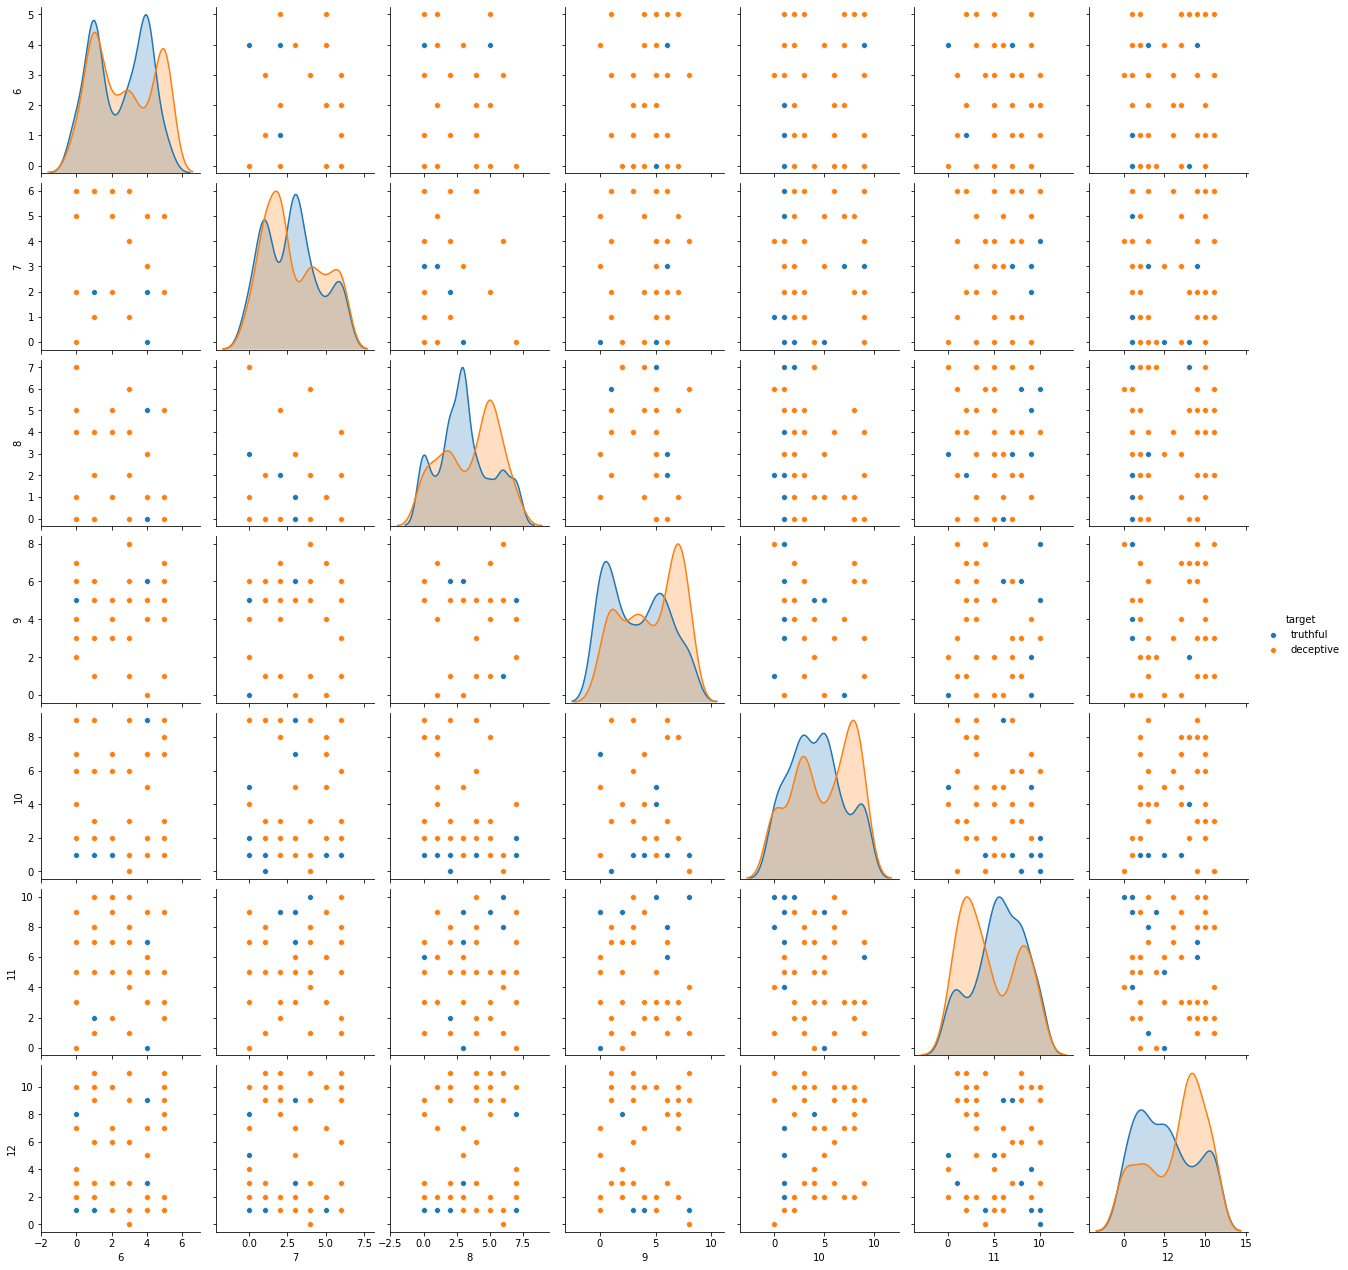

In [20]:
sns.pairplot(k_df, hue='target')

In [39]:
# dataframe for plotting selected k above
bigram_plus_cluster = kmeans_cluster(9, x_feat_sc)
bigram_plus_df = x_tr.drop(['hotel', 'polarity', 'source'], axis=1).copy()
bigram_plus_df['cluster']=pd.Series(bigram_plus_cluster.labels_, index=bigram_nmf['og_index'])
bigram_plus_df['target'] = y_tr

In [22]:
# if opts.n_components:
#     original_space_centroids = svd.inverse_transform(km.cluster_centers_)
#     order_centroids = original_space_centroids.argsort()[:, ::-1]
# else:
#     order_centroids = km.cluster_centers_.argsort()[:, ::-1]

# terms = vectorizer.get_feature_names()
# for i in range(true_k):
#     print("Cluster %d:" % i, end='')
#     for ind in order_centroids[i, :10]:
#         print(' %s' % terms[ind], end='')
#     print()
    

## Second: Bi-gram with topics only

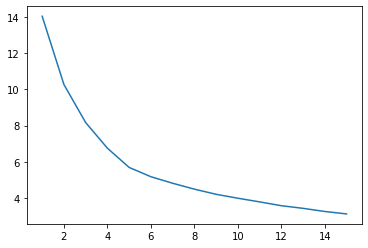

In [23]:
x_no_feat, y_no_feat = elbow_test(bigram_nmf.drop('og_index', axis=1))

plt.plot(x_no_feat, y_no_feat)

In [24]:
k_df_nmf_only=kmeans_cluster_range(bigram_nmf.drop('og_index',axis=1),7,12)
k_df_nmf_only['target'] = y_tr

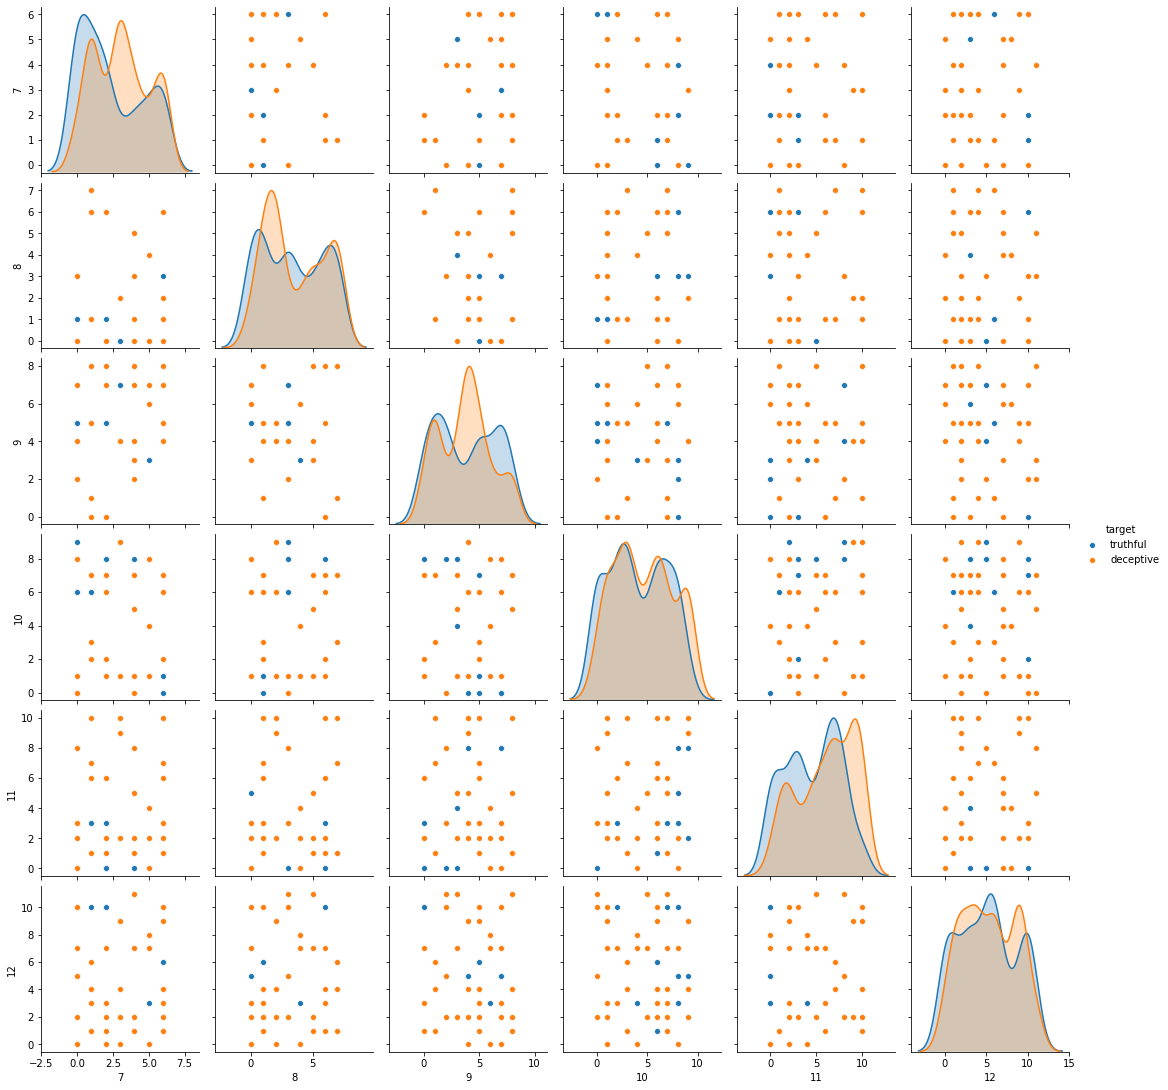

In [25]:
sns.pairplot(k_df_nmf_only, hue='target')

In [26]:
# DF to pick out the best k based on pair-wise above
# run the kmeans on k, add the cluster labels, add the target
bigram_only_cluster = kmeans_cluster(7, bigram_nmf.drop('og_index',axis=1))
bigram_only_df = x_tr.drop(['hotel', 'polarity', 'source'], axis=1).copy()
bigram_only_df['cluster']=pd.Series(bigram_only_cluster.labels_,index=bigram_nmf['og_index'])
bigram_only_df['target'] = y_tr

## Third: Uni-gram with additional features

In [27]:
x_uni_plus = add_features_to_topics(uni_gram_nmf, x_tr)

<ipython-input-7-2c6173dda70c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svd_df['og_index'] = old_idx_df.index


In [28]:
uni_scaler = StandardScaler()
x_uni_sc = uni_scaler.fit_transform(x_uni_plus)

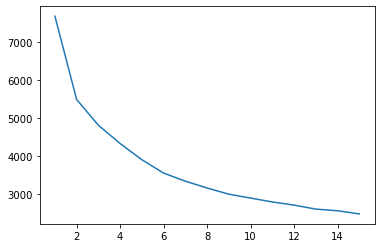

In [29]:
x_uni_inertia, y_uni_inertia = elbow_test(x_uni_sc)

plt.plot(x_k, y_inertia)

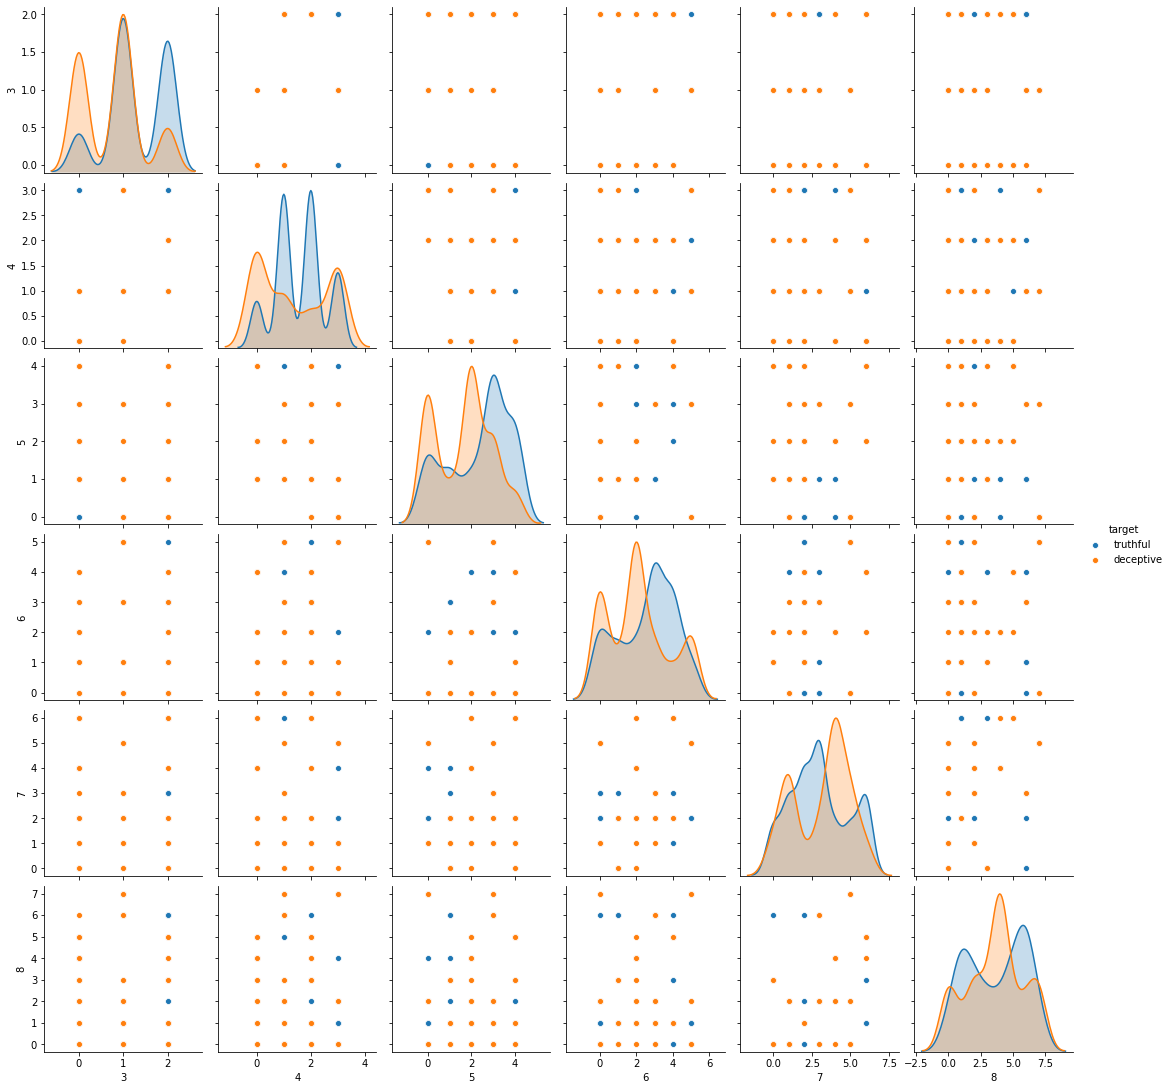

In [30]:
k_uni_df=kmeans_cluster_range(x_uni_sc,3,8)
k_uni_df['target'] = y_tr
sns.pairplot(k_uni_df, hue='target')

In [31]:
unigram_plus_cluster = kmeans_cluster(7, x_uni_sc)
unigram_plus_df = x_tr.drop(['hotel', 'polarity', 'source'], axis=1).copy()
unigram_plus_df['cluster']=pd.Series(unigram_plus_cluster.labels_, index=uni_gram_nmf['og_index'])
unigram_plus_df['target'] = y_tr

## Fourth: Uni-gram with topics only

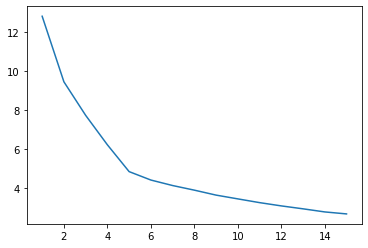

In [32]:
x_uni_elbow, y_uni_elbow = elbow_test(uni_gram_nmf.drop('og_index', axis=1))

plt.plot(x_uni_elbow, y_uni_elbow)

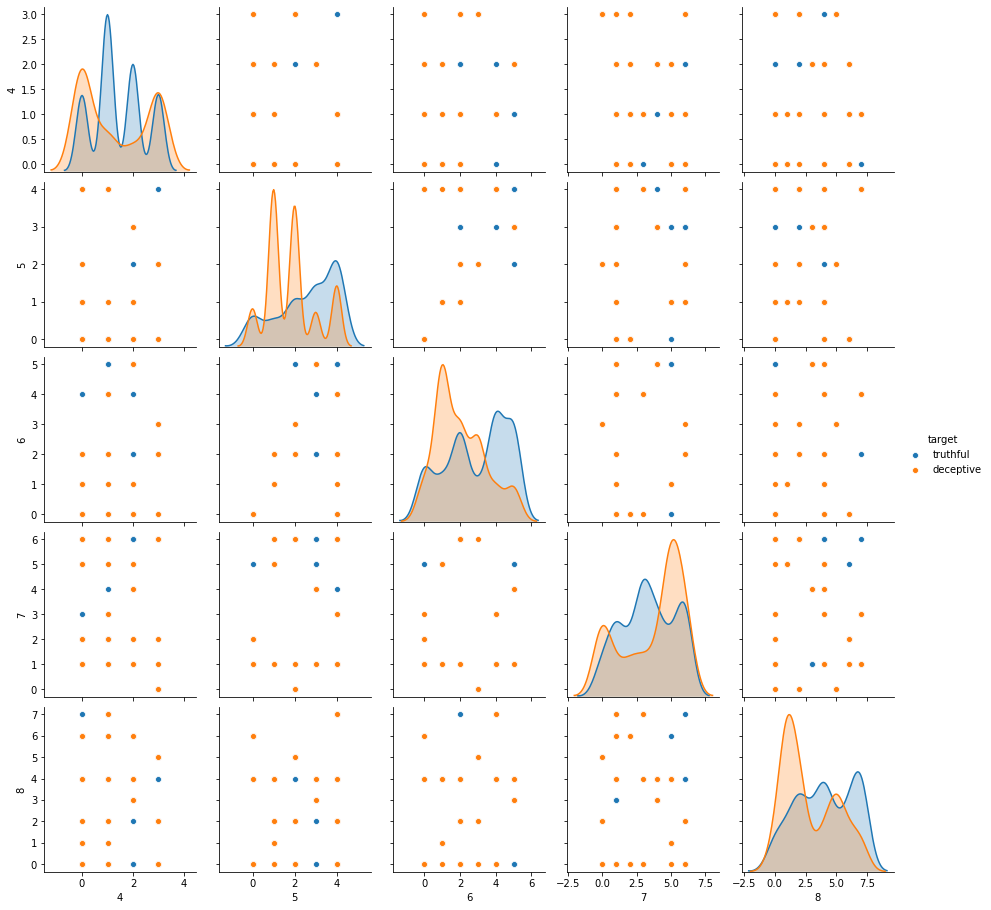

In [33]:
k_df_ug_only=kmeans_cluster_range(uni_gram_nmf.drop('og_index', axis=1),4,8)
k_df_ug_only['target'] = y_tr
sns.pairplot(k_df_ug_only, hue='target')

In [34]:
unigram_only_cluster = kmeans_cluster(5, uni_gram_nmf.drop('og_index', axis=1))
unigram_only_df = x_tr.drop(['hotel', 'polarity', 'source'], axis=1).copy()
unigram_only_df['cluster']=pd.Series(unigram_only_cluster.labels_,index=uni_gram_nmf['og_index'])
unigram_only_df['target'] = y_tr

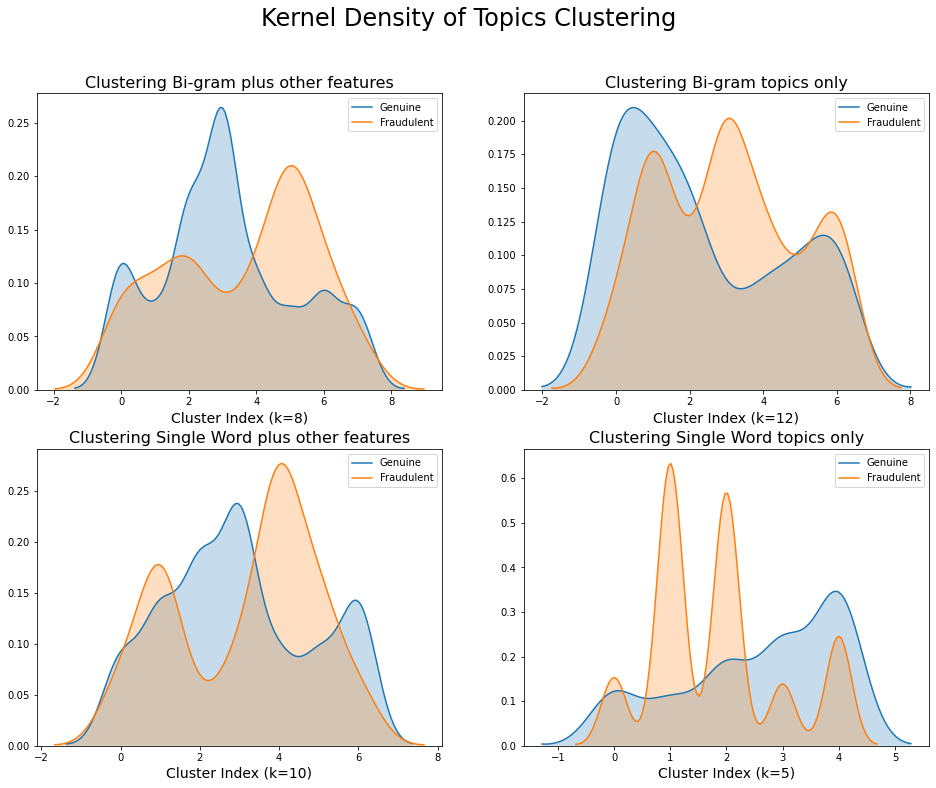

In [35]:
fig, axs = plt.subplots(2,2, figsize=(16,12))
fig.suptitle('Kernel Density of Topics Clustering', fontsize=24)

axs[0,0].set_title('Clustering Bi-gram plus other features', fontsize=16)
axs[0,0].set_xlabel('Cluster Index (k=8)', fontsize=14)
sns.kdeplot(bigram_plus_df[bigram_plus_df['target'] == 'truthful'].cluster, 
            shade=True, label='Genuine', ax=axs[0][0])
sns.kdeplot(bigram_plus_df[bigram_plus_df['target'] == 'deceptive'].cluster, 
            shade=True, label='Fraudulent', ax=axs[0][0])

axs[0,1].set_title('Clustering Bi-gram topics only', fontsize=16)
axs[0,1].set_xlabel('Cluster Index (k=12)', fontsize=14)
sns.kdeplot(bigram_only_df[bigram_only_df['target'] == 'truthful'].cluster, 
            shade=True, label='Genuine', ax=axs[0][1])
sns.kdeplot(bigram_only_df[bigram_only_df['target'] == 'deceptive'].cluster, 
            shade=True, label='Fraudulent', ax=axs[0][1])

axs[1,0].set_title('Clustering Single Word plus other features', fontsize=16)
axs[1,0].set_xlabel('Cluster Index (k=10)', fontsize=14)
sns.kdeplot(unigram_plus_df[unigram_plus_df['target'] == 'truthful'].cluster, 
            shade=True, label='Genuine', ax=axs[1][0])
sns.kdeplot(unigram_plus_df[unigram_plus_df['target'] == 'deceptive'].cluster, 
            shade=True, label='Fraudulent', ax=axs[1][0])

axs[1,1].set_title('Clustering Single Word topics only', fontsize=16)
axs[1,1].set_xlabel('Cluster Index (k=5)', fontsize=14)
sns.kdeplot(unigram_only_df[unigram_only_df['target'] == 'truthful'].cluster, 
            shade=True, label='Genuine', ax=axs[1][1])
sns.kdeplot(unigram_only_df[unigram_only_df['target'] == 'deceptive'].cluster, 
            shade=True, label='Fraudulent', ax=axs[1][1])


In [40]:
bigram_plus_analysis = pd.crosstab(index=bigram_plus_df['cluster'],columns=bigram_plus_df['target'],
            values=bigram_plus_df['target'], aggfunc='count')
bigram_plus_analysis['% Deceptive'] = bigram_plus_analysis['deceptive'] / (bigram_plus_analysis['deceptive']+bigram_plus_analysis['truthful'])
bigram_plus_analysis

target,deceptive,truthful,% Deceptive
cluster,,,
0,24,95,0.201681
1,73,79,0.480263
2,29,31,0.483333
3,52,46,0.530612
4,50,30,0.625000
5,29,66,0.305263
6,53,61,0.464912
7,117,22,0.841727
8,62,41,0.601942


In [37]:
bigram_plus_cluster.cluster_centers_

array([[-3.27127282e-01,  5.56728788e-01, -1.64566852e-01,
        -4.75569452e-01, -5.50348797e-01, -9.15948854e-01,
         5.65977082e-01, -2.68504090e-01],
       [ 2.80719768e-01, -1.02179403e+00,  2.26323713e-01,
         1.71005611e+00,  1.96903651e-01,  1.01469124e+00,
         9.01841240e-01, -5.98839360e-01],
       [-5.13833368e-01,  7.54864384e-01, -4.09439744e-01,
        -5.03781417e-01, -4.42224181e-01, -8.70859594e-01,
        -1.16489608e+00,  5.32786376e-04],
       [ 1.61513263e+00, -5.84376166e-01,  1.63704761e-02,
        -3.73062960e-01, -2.71119482e-01,  9.41063776e-01,
         3.83647722e-01, -2.98468824e-01],
       [-4.59326990e-01,  9.57038250e-02, -8.39716257e-02,
         1.39488791e+00, -5.00713695e-01, -8.88423765e-01,
        -3.72514517e-01,  9.22221854e-02],
       [-3.23655514e-01, -7.55200859e-01, -3.15488467e-01,
        -2.78130133e-01,  1.65658367e+00,  8.69221223e-01,
         1.77557454e-01, -3.18572828e-01],
       [-5.16605299e-01,  1.572873

In [38]:
unigram_only_df
unigram_only_analysis = pd.crosstab(index=unigram_only_df['cluster'],columns=unigram_only_df['target'],
            values=unigram_only_df['target'], aggfunc='count')
unigram_only_analysis['% Deceptive'] = unigram_only_analysis['deceptive'] / (unigram_only_analysis['deceptive']+bigram_plus_analysis['truthful'])
unigram_only_analysis

target,deceptive,truthful,% Deceptive
cluster,,,
0,43,59,0.413462
1,178,48,0.847619
2,160,87,0.655738
3,39,109,0.229412
4,69,168,0.589744


In [ ]:
#decipher centroids
unigram_only_cluster.cluster_centers_

# Other Clustering Methods

In [ ]:
x_feat

In [ ]:
#different sets to fit on alternate clustering
x_feat_sc
bigram_nmf.drop('og_index',axis=1)
x_uni_sc
uni_gram_nmf.drop('og_index', axis=1)

In [ ]:
uni_gram_nmf.index = uni_gram_nmf['og_index']

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=8, covariance_type='full', random_state=444).fit(uni_gram_nmf.drop('og_index', axis=1))
labels = gmm.predict(uni_gram_nmf.drop('og_index', axis=1))

In [ ]:
gmm_df = uni_gram_nmf.drop('og_index', axis=1).copy()
gmm_df['cluster']=pd.Series(labels, index=uni_gram_nmf['og_index'])
gmm_df['target'] = y_tr

In [ ]:
sns.kdeplot(gmm_df[gmm_df['target'] == 'truthful'].cluster, 
            shade=True, label='Genuine')
sns.kdeplot(gmm_df[gmm_df['target'] == 'deceptive'].cluster, 
            shade=True, label='Fraudulent')

## Gaussian Mixture Model isn't working well

In [ ]:
foo = pd.crosstab(index=gmm_df['cluster'],columns=gmm_df['target'],values=gmm_df['target'], aggfunc='count')

In [ ]:
foo['% Deceptive'] = foo['deceptive'] / (foo['deceptive']+foo['truthful'])
foo

# DBScan

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN

In [ ]:
range_eps = np.arange(.7,1.5, .01)

for i in range_eps:
    db = DBSCAN(eps=i, min_samples=5).fit(x_feat_sc)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    silhouette_avg = silhouette_score(x_feat_sc, labels)
    foo = [x for x in labels if x !=-1]
    
    print("For eps value =" + str(i),
         "The average silhouette_score is:", silhouette_avg,
         "unique labels"+str(pd.Series(foo).value_counts()))

In [ ]:
db = DBSCAN(eps=1.04, min_samples=4).fit(x_feat_sc)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
pd.Series(labels).value_counts()

In [ ]:
x_feat

In [ ]:
# swap kmeans with Gaussian here

def text_pipeline(input_df, gmm, add_feat=False):
    file_df = cft.main_clean(input_df.drop(['hotel','polarity','source'], axis=1))
    ngrams = (1,2)
    nmf = ht.nmf_model(file_df, 15, ngrams)
    if add_feat:
        pipeline_df = add_features_to_topics(nmf, input_df)
    else:
        pipeline_df = nmf
    cluster = gmm.predict(pipeline_df)
    pipeline_df['cluster']=pd.Series(cluster,index=input_df.index)
    return pipeline_df

score_val = text_pipeline(x_va, gmm, True)
#pipeline_df['target'] = y_tr